# Ovarian cancer logistic regression using ADVI

In [ ]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

from tqdm import tqdm

from pathlib import Path
from random import choices
import importlib


In [1]:

from tensorflow_probability.substrates.jax import tf2jax as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis

2024-04-09 05:51:07.553504: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 05:51:07.580465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 05:51:07.580499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 05:51:07.581416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 05:51:07.586151: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 05:51:07.587002: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [ ]:
from ucimlrepo import fetch_ucirepo 


In [ ]:
dataset = "ovarian"
# dataset = "breast"
use_saved = False

if dataset == "breast":
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  

    # data (as pandas dataframes) 
    batch_size=151
    X_ = cdc_diabetes_health_indicators.data.features
    y_ = cdc_diabetes_health_indicators.data.targets

    X_ = X_.fillna(0)
    batch_size=300
    
else:
    X = pd.read_csv(f"{importlib.resources.path('bayesianquilts', 'data')}/overianx.csv", header=None)
    y = pd.read_csv(f"{importlib.resources.path('bayesianquilts', 'data')}/overiany.csv", header=None)
    batch_size = 6

X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(54, 1536)


In [ ]:
ndx = np.abs(X_scaled).sum(axis=1).sort_values(ascending=False)[:10].index

In [ ]:
X_scaled = pd.concat([X_scaled.loc[ndx, :]*5, X_scaled], axis=0)
y_ = pd.concat([ 1-y_.loc[ndx, :], y_], axis=0)

In [ ]:
X_scaled = (X_scaled - X_scaled.mean())/X_scaled.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(64, 1536)


In [ ]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [10]:
if not use_saved:

    lr_model = LogisticRegression2(dim_regressors=p)

        
else:
    import dill as pickle
    import gzip
    if dataset == 'ovarian':
        with gzip.open("ovarian_gwas.gz", 'rb') as f:
            lr_model = pickle.load(f)
    else:
        with gzip.open("breast.gz", 'rb') as f:
            lr_model = pickle.load(f)

Set up Bayesian minibatch ADVI inference

In [11]:

losses = lr_model.fit(
    data_factory_factory(shuffle=True, repeat=True),
    dataset_size=n,
    batches_per_step=9,
    check_every=int(n/batch_size)*50,
    batch_size=batch_size,
    num_steps=10000,
    max_decay_steps=10,
    max_plateau_epochs=100,
    sample_size=36,
    learning_rate=0.0005,
    lr_decay_factor=0.9
    )



Running optimization for 10000 steps of 9 accumulated batches, checking every 500 steps
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-1


  5%|▍         | 498/10000 [00:37<11:16, 14.05it/s]

Step 500: average-batch loss:6009.501181510705 rel loss: 1.6640316222529039e+304
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-2


 10%|▉         | 998/10000 [01:14<13:29, 11.13it/s]

Step 1000: average-batch loss:5740.605956187287 rel loss: 0.04684091320248157
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-3


 15%|█▍        | 1498/10000 [01:51<10:09, 13.95it/s]

Step 1500: average-batch loss:5504.670339682717 rel loss: 0.0428609892955314
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-4


 20%|█▉        | 1998/10000 [02:28<09:28, 14.08it/s]

Step 2000: average-batch loss:5295.040126862466 rel loss: 0.0395899195847011
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-5


 25%|██▍       | 2498/10000 [03:04<10:04, 12.42it/s]

Step 2500: average-batch loss:5108.175526052123 rel loss: 0.036581476078360695
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-6


 30%|██▉       | 2998/10000 [03:41<08:20, 14.00it/s]

Step 3000: average-batch loss:4941.064283133922 rel loss: 0.033820900385495324
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-7


 35%|███▍      | 3498/10000 [04:18<08:02, 13.49it/s]

Step 3500: average-batch loss:4793.280148275337 rel loss: 0.030831524610919994
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-8


 40%|███▉      | 3998/10000 [04:55<07:07, 14.04it/s]

Step 4000: average-batch loss:4662.384373729868 rel loss: 0.028074856994416694
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-9


 45%|████▍     | 4498/10000 [05:32<06:19, 14.50it/s]

Step 4500: average-batch loss:4547.56602739204 rel loss: 0.025248307698277413
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-10


 50%|████▉     | 4998/10000 [06:08<05:45, 14.46it/s]

Step 5000: average-batch loss:4448.913149815499 rel loss: 0.022174601808226394
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-11


 55%|█████▍    | 5498/10000 [06:44<05:26, 13.78it/s]

Step 5500: average-batch loss:4366.538121863487 rel loss: 0.018865065562935684
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-12


 60%|█████▉    | 5998/10000 [07:21<05:02, 13.24it/s]

Step 6000: average-batch loss:4301.1483268541615 rel loss: 0.0152028691038309
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-13


 65%|██████▍   | 6498/10000 [07:58<04:15, 13.73it/s]

Step 6500: average-batch loss:4251.164155123183 rel loss: 0.011757760911382607
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-14


 70%|██████▉   | 6998/10000 [08:34<03:38, 13.73it/s]

Step 7000: average-batch loss:4211.5611622009865 rel loss: 0.009403399688846032
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-15


 75%|███████▍  | 7498/10000 [09:11<03:06, 13.41it/s]

Step 7500: average-batch loss:4177.601151751924 rel loss: 0.008129069582150341
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-16


 80%|███████▉  | 7998/10000 [09:48<02:42, 12.31it/s]

Step 8000: average-batch loss:4147.597026390761 rel loss: 0.007234098484073835
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-17


 85%|████████▍ | 8498/10000 [10:25<02:01, 12.32it/s]

Step 8500: average-batch loss:4119.836399819945 rel loss: 0.006738283727001792
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-18


 90%|████████▉ | 8998/10000 [11:02<01:11, 14.05it/s]

Step 9000: average-batch loss:4094.2867917059557 rel loss: 0.006240307387783982
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-19


 95%|█████████▍| 9498/10000 [11:38<00:38, 12.94it/s]

Step 9500: average-batch loss:4070.471527892454 rel loss: 0.005850738335917629
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-20


100%|█████████▉| 9998/10000 [12:15<00:00, 13.55it/s]

Step 10000: average-batch loss:4049.191121932917 rel loss: 0.005255470862876559
Saved a checkpoint: /tmp/tfcheckpoints/a66a8794-bce4-4b2d-a923-2ec589a66716/a66a8794-bce4-4b2d-a923-2ec589a66716-21


100%|██████████| 10000/10000 [12:15<00:00, 13.29it/s]

Terminating because we are out of iterations


100%|██████████| 10000/10000 [12:15<00:00, 13.59it/s]


11it [00:00, 18.16it/s]


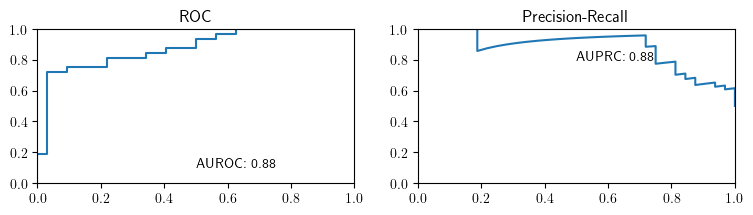

In [12]:
def prediction_fn(data):
    params = lr_model.sample(128)
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

_ = plt.savefig("roccurve.pdf", bbox_inches='tight')

In [13]:
if dataset == "ovarian":
    batch = next(iter(data_factory_factory(batch_size=56)()))
else:
    batch = next(iter(data_factory_factory()()))
params = lr_model.sample(128)


In [14]:
params.keys()

dict_keys(['z', 'tau', 'lambda', 'caux', 'beta0', 'beta'])

In [15]:
params['beta0'].shape

TensorShape([128, 1])

ValueError: not enough values to unpack (expected 2, got 1)

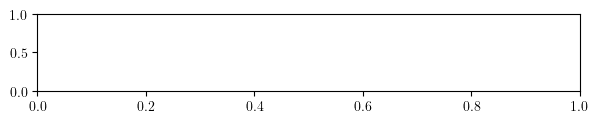

In [16]:
beta = tf.reduce_mean(params['beta'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, cmap='seismic_r')
plt.colorbar(im)

In [ ]:
h_vals = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
loo_khat = {}
reduced_ndx = {}
high_khat_ndx = {}
n_sample = [128]
records = []
for n_samples in n_sample:
    sample_ndx = choices(range(2000), k=n_samples)
    reduced_ndx[n_samples] = []
    high_khat_ndx[n_samples] = {}
    print(f"Samples: {n_samples}")
    loo_khat[n_samples] = {}
    params = fit.stan_variables()

    params['c'] = params['c'][:, tf.newaxis]
    params['tau'] = params['tau'][:, tf.newaxis]
    params['caux'] = params['caux'][:, tf.newaxis]
    params['beta0'] = params['beta0'][:, tf.newaxis]
    params = {k: v[sample_ndx] for k, v in params.items()}
    


    for h in h_vals:
        loo_khat[n_samples][h] = {}
        loo = adaptive_is_loo(lr_model, batch, params, h, variational=False)
        khat = pd.DataFrame({"khat": loo["I"]['khat']})
        khat = khat.loc[khat.khat> 0.7] 
        ndx = np.array(khat.index)
        high_khat_ndx[n_samples][h] = np.where((loo['I']['khat']>0.7))
        print(f"rho={h}\n")
        for T in ["I", "LL", "KL", "Var"]:
            loo_khat[n_samples][h][T] = np.array(loo[T]['khat'])
            
            records += [
                {
                    "h": h,
                    "T": T,
                    "S": n_samples,
                    "khat": loo[T]['khat'],
                    "khat_high": loo[T]['khat'][ndx],
                    "p_psis": loo[T]['p_psis'].numpy(),
                    "khat>0.7": np.where((loo['I']['khat']>0.7))[0],
                    "n>0.7": (np.where((loo['I']['khat']>0.7))[0]).shape
                }
            ]
            # print(f"Transform: {T}")
            #print(
            #    f"V: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} S: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
            #)
            #print(f"k-hat reduction for these k-hat>0.7 obs: {np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7))}")
            reduced_ndx[n_samples] += [np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7) * (loo[T]['khat']<0.7))]
            #print(f"k-hat reduction to below 0.7 for these k-hat>0.7 obs: {reduced_ndx[n_samples][-1]}")
            
for n_samples in n_sample:
    high_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in high_khat_ndx[n_samples].values()]))
    reduced_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in reduced_ndx[n_samples]]))
    high_ndx_ = set(high_ndx_)
    reduced_ndx_ = set(reduced_ndx_)
    print(len(high_ndx_), len(reduced_ndx_))
        

Samples: 128


NameError: name 'fit' is not defined

In [ ]:

loo = adaptive_is_loo(lr_model, batch, params, .2, variational=True)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

NameError: name 'batch' is not defined

In [ ]:
loo["I"]['khat'] - loo['KL']['khat']

NameError: name 'loo' is not defined

# Compute LOO AU ROC/PRC

In [ ]:
step_size = 0.2
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_loo']
    return pred



In [ ]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



Step-away LOO

NameError: name 'bench_stepaway_loo' is not defined

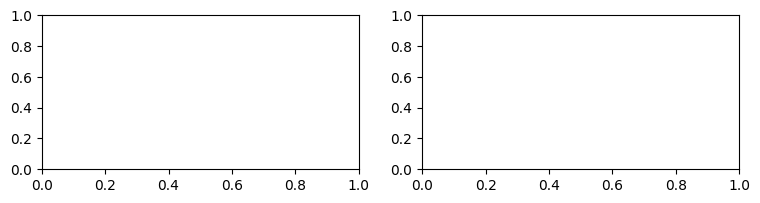

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

NameError: name 'bench_loo' is not defined

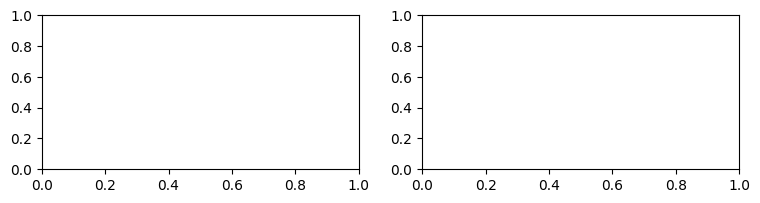

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))
_ = plt.savefig("roc_curves.pdf")

Training data metrics

In [ ]:
bench['auroc']['auroc']

0.6630859375

In [ ]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(batch_size=1000, repeat=False)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=True)]

0it [00:00, ?it/s]

1it [00:01,  1.40s/it]


In [ ]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [ ]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

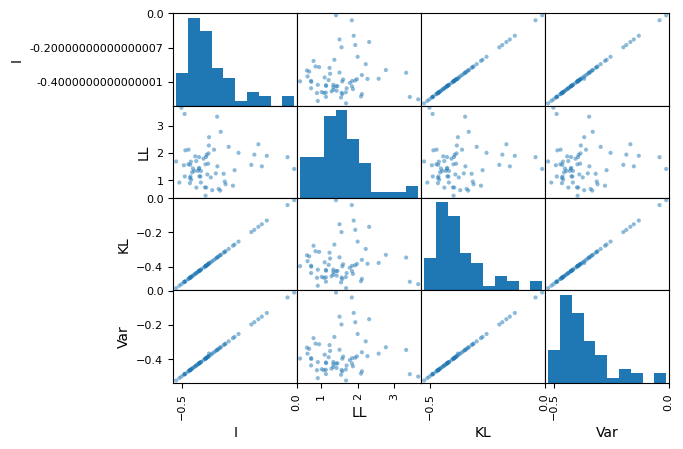

In [ ]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


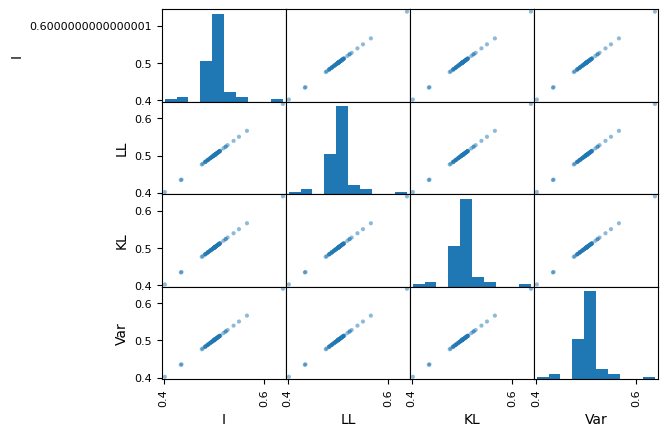

In [ ]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [ ]:
khat.describe()

,I,LL,KL,Var
count,64.000000,64.000000,64.000000,64.000000
mean,-0.376368,1.542146,-0.376311,-0.376151
std,0.109366,0.668750,0.109364,0.109368
min,-0.526238,0.417989,-0.526238,-0.526238
25%,-0.453600,1.116624,-0.453600,-0.453600
50%,-0.397998,1.472764,-0.397998,-0.397998
75%,-0.338923,1.875054,-0.338923,-0.338923
max,-0.011068,3.663036,-0.011068,-0.011068


In [ ]:
khat[khat.I > 0.5]

,I,LL,KL,Var


In [ ]:
(khat>0.5).describe()

,I,LL,KL,Var
count,64,64,64,64
unique,1,2,1,1
top,False,True,False,False
freq,64,63,64,64
